# TP2 Reconstruction of DOSY NMR signals - Part I

* Authors: Mengda Li, Ségolène Martin

## 1 Introduction


Our goal of optimization: find 

$$ \bar{x} = \underset{x \in \mathbb{R}^N}{\arg\min}
\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta g(x)$$

where $g \in \Gamma_0(\mathbb{R}^N)$ denotes a regularization term and $\beta ≥ 0$.

## 2 Generation of synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log
from scipy import linalg

T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

1. Download on the website the diffusion signal  $\bar{x}$

In [6]:
original_signal = np.loadtxt('x.txt')

2. Create $T$ using an exponential sampling strategy

In [15]:
def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(1, N+1))

3. Display the original signal $\bar{x}$ as a function of $T$ (use log scale on the horizontal axis).

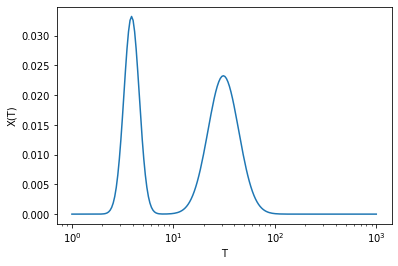

In [16]:
plt.plot(T, original_signal)
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

4. Create $t$ using a regular sampling strategy

In [17]:
def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(1, M+1))

5. Construct matrix $K$

In [18]:
K = exp(-np.tensordot(t, T, axes = 0))

6. Simulate the noisy data $y = K \bar{x} + w$

In [20]:
z = K @ original_signal
sigma = 0.01 * z[0]
I_M = np.identity(M)
cov = sigma**2 * I_M
mean = np.zeros(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

7. Display the resulting noisy data $y$ as a function of $t$.

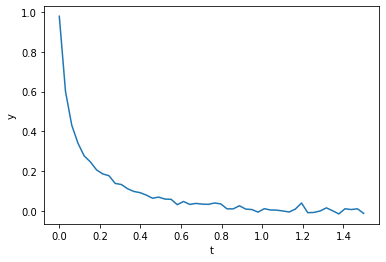

In [21]:
plt.plot(t, y)
plt.ylabel("y")
plt.xlabel('t');

## 3 Comparison of regularization strategies

* ###  case 1: **Smoothness prior**

$$g(x) = \frac{1}{2} \lVert Dx \rVert^2$$

with $D = 
\begin{pmatrix}
    1       & 0 & 0 & \dots & -1 \\
    -1      & 1 & 0 & \dots & 0 \\
    \vdots & \ddots & \ddots \\
    0       & 0 & \dots &  -1 &1
\end{pmatrix} \in \mathbb{R}^{N \times N}$

We want to minimize the function 

\begin{align}
f(x) &= \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + 
\beta \frac{1}{2} \lVert Dx \rVert^2 \\
    & =\frac{1}{2} x^T(K^T K + \beta D^T D) x - y^T K x + \frac{1}{2}\|y\|^2
\end{align}

with $$\nabla f(x) = (K^T K + \beta D^T D) x - K^T y$$

#### 1. Discuss the existence and uniqueness of a solution to the problem.

So the problem is a **quadratic minimization problem**.
* if $(K^T K + \beta D^T D) \succ 0$, then there is a unique solution, 
$$\hat{x} =(K^T K + \beta D^T D)^{-1} K^T y $$

* In the more general case when $K^T K + \beta D^T D$ is not positive definite, any solution of $(K^T K + \beta D^T D) \hat{x} = K^T y$ is optimal

* If $(K^T K + \beta D^T D) \hat{x} = K^T y$ does not have a solution, then the problem is unbounded below.

#### 2. Propose an approach to solve problem

The key is to solve the linear system
$$(K^T K + \beta D^T D) \hat{x} = K^T y \tag{*}$$
&nbsp; &nbsp;&nbsp;&nbsp;if there is a solution $\hat{x}$ for $(*)$, then it is the optimum. 

We can use `scipy.linalg.solve` to solve this system numerically if $(K^T K + \beta D^T D)$ is not singular.

#### 3. Implement it, and display the restored signal $\bar{x}$

We show the restored signal with $\beta = 1, \beta = 10, \beta = 100$ in this question. Unfortunately, we have ill-conditioned matrix in the linear system.

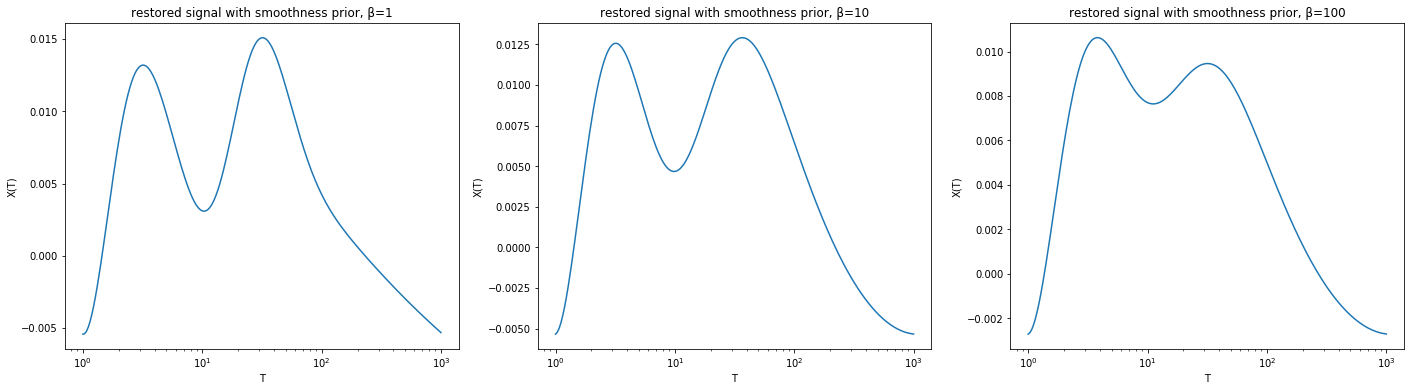

In [22]:
beta = 1

D = np.identity(N)
D[0, -1] = -1
for i in range(1, N):
    D[i, i-1] = -1
  
K_SQUARE = K.T @ K
D_SQUARE = D.T @ D
KY = K.T @ y

plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
restored_signal_smooth_1 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
plt.plot(T, restored_signal_smooth_1)
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
beta = 10
restored_signal_smooth_10 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_10)
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
beta = 100
restored_signal_smooth_100 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_100)
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

#### 4. Compute the normalized quadratic error between $\hat{x}$ and $\bar{x}$.

We show the normalized quadratic error with $\beta = 1, \beta = 10, \beta = 100$ in this question.

In [23]:
X_BAR_SQUARE = np.dot(original_signal, original_signal)

def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

error_smooth_1 = normalized_quadratic_error(restored_signal_smooth_1)
print('error = {} with \u03B2={}'.format(error_smooth_1, 1))

error_smooth_10 = normalized_quadratic_error(restored_signal_smooth_10)
print('error = {} with \u03B2={}'.format(error_smooth_10, 10))

error_smooth_100 = normalized_quadratic_error(restored_signal_smooth_100)
print('error = {} with \u03B2={}'.format(error_smooth_100, 100))

error = 0.3405566694285181 with β=1
error = 0.43200256609556137 with β=10
error = 0.4730866103982137 with β=100


#### 5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

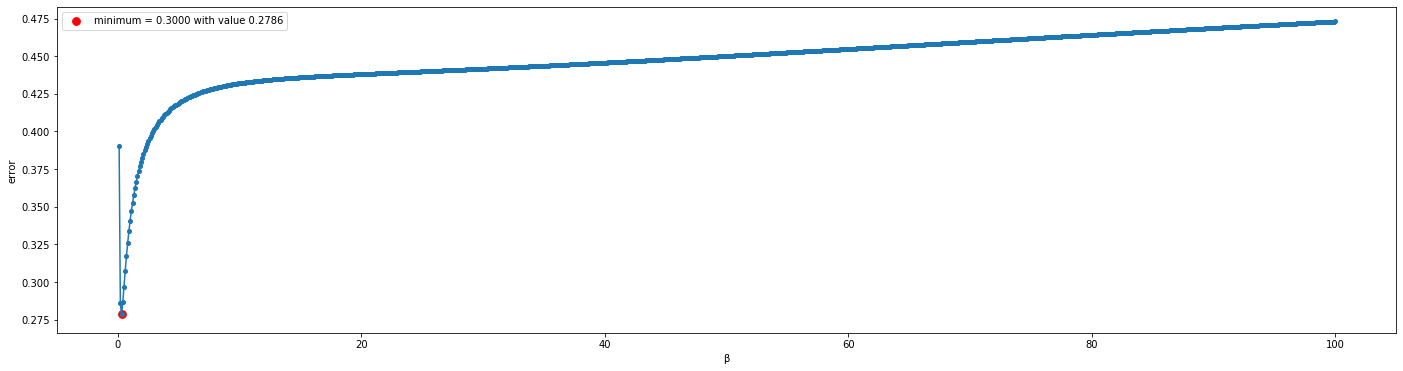

In [51]:
def error_smooth_beta(beta):
    restored_signal_smooth = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
    error_smooth = normalized_quadratic_error(restored_signal_smooth)
    return error_smooth

error_smooth_beta = np.vectorize(error_smooth_beta)

Beta = np.linspace(0.1, 100, 1000)
Error_smooth = error_smooth_beta(Beta)

plt.plot(Beta, Error_smooth, 'o-', markersize=4)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_smooth)
minimum = Beta[min_index]
min_val = Error_smooth[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();